In [85]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
#import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
#from keras.utils import np_utils

In [86]:
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
#print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

In [87]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = read_data('WISDM_ar_v1.1_raw.txt')

In [88]:
df.shape

(1098203, 6)

In [90]:
#df.to_csv("wisdm.csv", index=False)

In [92]:
# Describe the data
show_basic_dataframe_info(df)
df.head(20)


Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


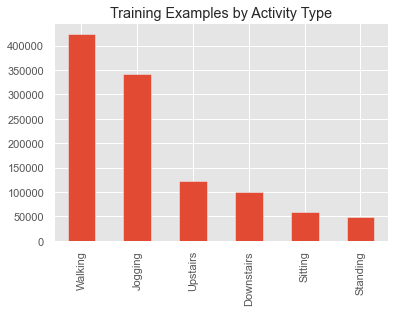

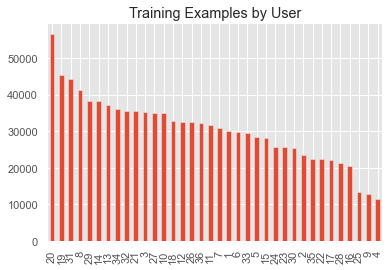

In [93]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()


As we can see, we have more data for walking and jogging activities than we have for the other activities. Also we can see that 36 persons have participated in the experiment.
Next, let’s take a look at the accelerometer data for each of the three axis for all six possible activities. The data is recorded at a sampling rate of 20 Hz (20 values per second). Since we show the first 180 records, each chart shows a 9 second interval for each of the six activities (calculation: 0.05 * 180 = 9 seconds). We will use two functions (which I have borrowed from here) to plot the data.

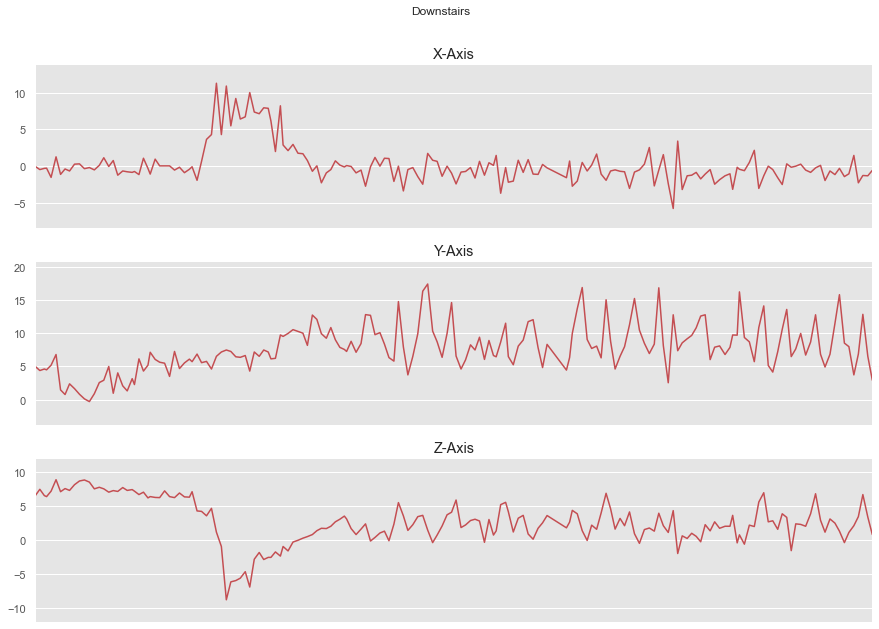

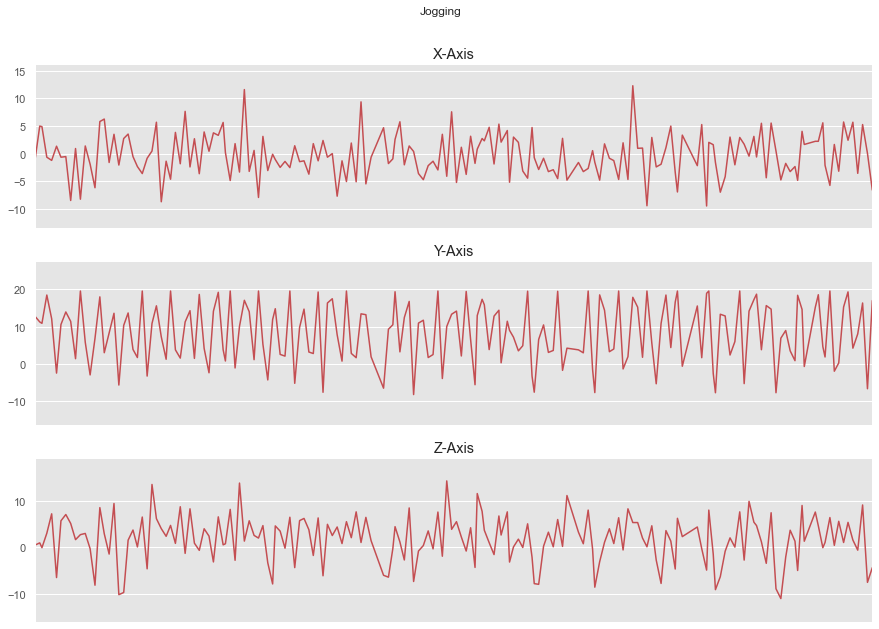

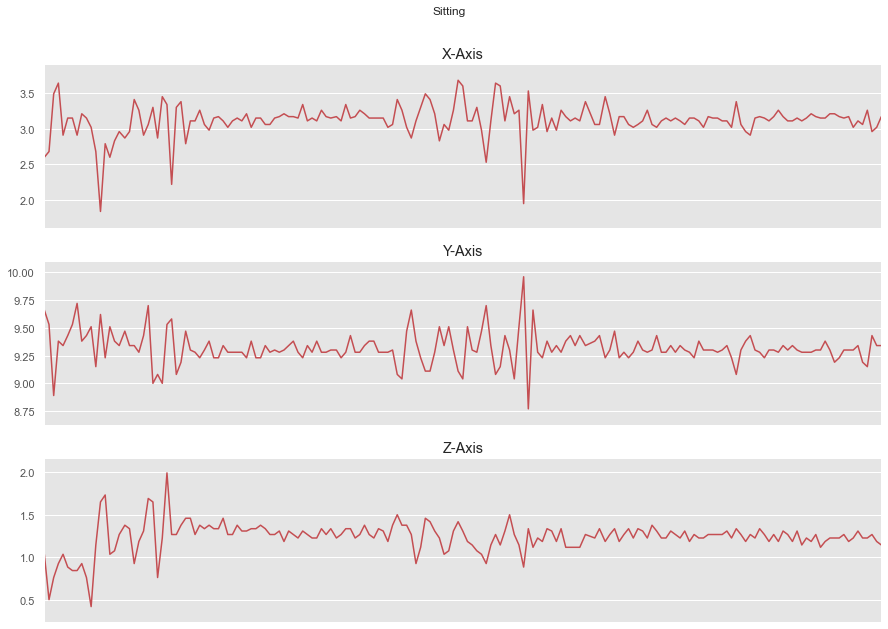

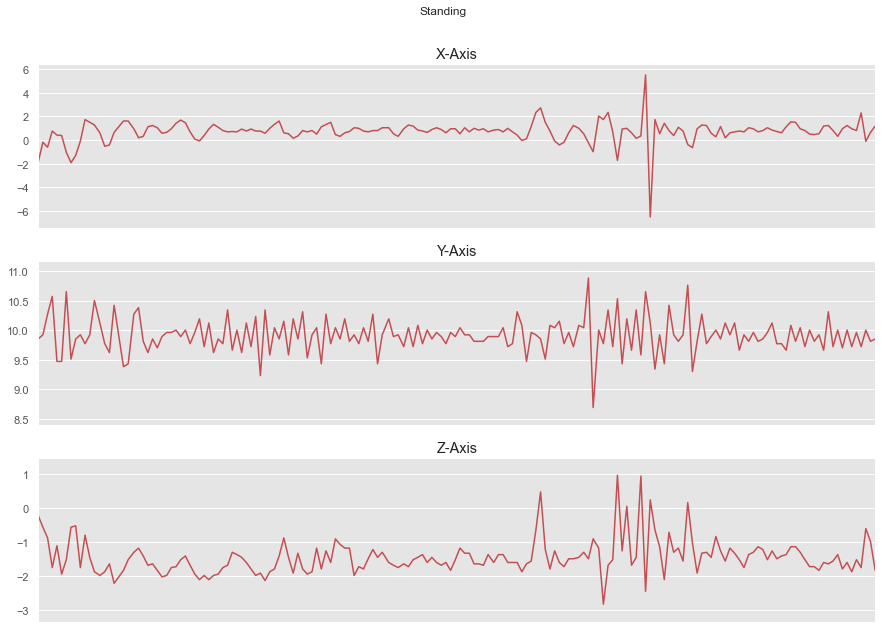

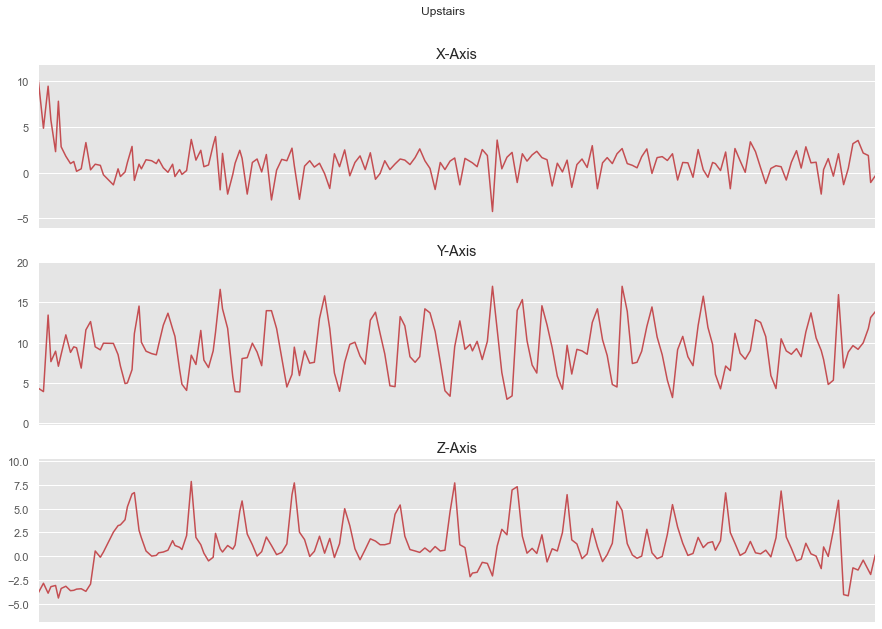

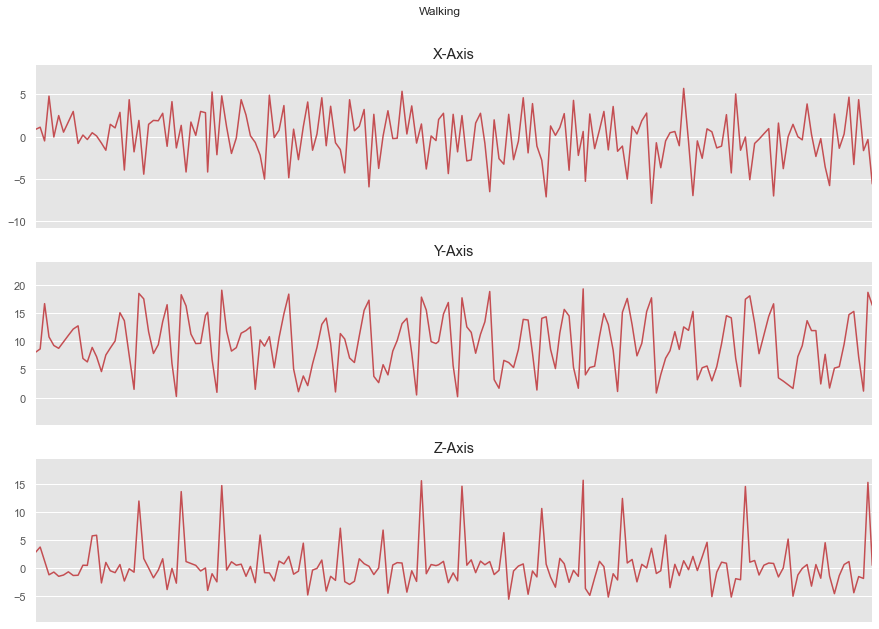

In [94]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

As expected, there is a higher acceleration for activities such as jogging and walking compared to sitting. Before we continue, we will add one more column with the name “ActivityEncoded” to the dataframe with the encoded value for each activity: Downstairs, Jogging, Sitting, Standing, Upstairs, Walking
This is needed since the deep neural network cannot work with non-numerical labels. With the LabelEncoder, we are able to easily to convert back to the original label text.

In [95]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [96]:
df.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1
3,33,Jogging,49106222305000,-0.6,18.5,3.0,1
4,33,Jogging,49106332290000,-1.2,12.1,7.2,1


Split Data into Training and Test Set
It is important to separate the whole data set into a training set and a test set. Often times, you see mistakes on how the data is split. However you decide to split the data, you never want information from the test set to bleed into your training set. This might be great for the overall performance of your model during training and then validation against the test set. But your model is very unlikely to generalize well for data it has not seen yet.
The idea behind splitting: We want our neural network to learn from a few persons which have been through the experiment. Next, we then want to see how well our neural network predicts the movements of persons it has not seen before.
Data Splitting to Avoid
Only worrying about having at least a few example records per activity is not sufficient. You will run the risk that you have maybe three records of activity “Walking” for person 5 in the training set and one record for activity “Walking” for person 5 in the test set. Of course, with this type of situation, your model will perform great because it has already seen the movement pattern of person 5 during training. Always be critical about the performance of your DNN — it might be because of the wrong data split in the first place.
Better Splitting Approach
In our case, let’s split based on the user IDs. We will keep users with ID 1 to 28 for training the model and users with ID greater than 28 for the test set.

In [99]:
# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]


In [100]:
df_test_new = df_test.drop('activity', axis=1)
df_test_new.to_csv("wisdm_test.csv", index=False)

In [101]:
df_train_new = df_train.drop('activity', axis=1)
df_train_new.to_csv("wisdm_train.csv", index=False)

Normalize Training Data
Next, we need to normalize our features within our training data. Of course there are various ways on how to normalize. Please keep in mind that you use the same normalization algorithm later when feeding new data into your neural network. Otherwise your preditions will be off. On top of the normalization we will also apply rounding to the three features.

In [64]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [65]:
df_train.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
8489,17,Walking,57869902574000,0.0,0.5,-0.0,5
8490,17,Walking,57870012316000,-0.0,0.5,-0.0,5
8491,17,Walking,57870122301000,-0.0,0.5,-0.0,5
8492,17,Walking,57870222246000,0.0,0.5,-0.0,5
8493,17,Walking,57870332292000,0.0,0.5,-0.0,5


Reshape Data into Segments and Prepare for Keras
The data contained in the dataframe is not ready yet to be fed into a neural network. Therefore we need to reshape it. Let’s create another function for this called “create_segments_and_labels”. This function will take in the dataframe and the label names (the constant that we have defined at the beginning) as well as the length of each record. In our case, let’s go with 80 steps (see constant defined earlier). Taking into consideration the 20 Hz sampling rate, this equals to 4 second time intervals (calculation: 0.05 * 80 = 4). Besides reshaping the data, the function will also separate the features (x-acceleration, y-acceleration, z-acceleration) and the labels (associated activity).

In [66]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

By now, you should have both 20.868 records in x_train as well as in y_train. Each of the 20.868 records in x_train is a two dimensional matrix of the shape 80x3.

In [67]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


For constructing our deep neural network, we should now store the following dimensions:
Number of time periods: This is the number of time periods within one record (since we wanted to have a 4 second time interval, this number is 80 in our case)
Number of sensors: This is 3 since we only use the acceleration over the x, y, and z axis
Number of classes: This is the amount of nodes for our output layer in the neural network. Since we want our neural network to predict the type of activity, we will take the number of classes from the encoder that we have used earlier.

In [68]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


The data that we would like to feed into our network is two dimensional (80x3). Unfortunately, Keras and Core ML in conjunction are not able to process multi-dimensional input data. Therefore we need to “flatten” the data for our input layer into the neural network. Instead of feeding a matrix of shape 80x3 we will feed in a list of 240 values.

In [69]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)


x_train shape: (20868, 240)
input_shape: 240


Before continuing, we need to convert all feature data (x_train) and label data (y_train) into a datatype accepted by Keras.

In [70]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

We are almost done with the preparation of our data. One last step we need to do is to conduct one-hot-encoding of our labels. Please only execute this line once!

In [71]:
from tensorflow.keras import utils

y_train_hot = utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (20868, 6)


Create Deep Neural Network Model in Keras
By now, you have completed all the heavy-lifting on your side. The data is ready in such a format that Keras will be able to process it. I have decided to create a neural network with 3 hidden layers of 100 fully connected nodes each (feel free to play around with the shape of the network or even switch to more complex ones like a convolutional neural network).
Important remark: as you remember, we have reshaped our input data from a 80x3 matrix into a vector of length 240 so that Apple’s Core ML can later process our data. In order to reverse this, our first layer in the neural network will reshape the data into the “old” format. The last two layers will again flatten the data and then run a softmax activation function in order to calculate the probability for each class. Remember, that we are working with six classes in our case (Downstairs, Jogging, Sitting, Standing, Upstairs, Walking).


In [72]:
model_m = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 80, 100)           400       
_________________________________________________________________
dense_5 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
dense_6 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 48006     
Total params: 68,606
Trainable params: 68,606
Non-trainable params: 0
__________________________________________________

Fit the DNN Model in Keras
Next, we will train the model with our training data that we have prepared earlier. We will define an early stopping callback monitor on training accuracy: if the training fails to improve for two consecutive epochs, then the training will stop with the best model. The hyperparameter used for the training are quite simple: We will use a batch size of 400 records and will train the model for 50 epochs. For model training, we will use a 80:20 split to separate training data and validation data. It is that simple. So let’s go ahead and train our model. There are some good explanations out there on the different hyperparameters, for instance here.

In [73]:
callbacks_list = [
    tensorflow.keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
42/42 [==============================] - 2s 42ms/step - loss: 1.0693 - accuracy: 0.6341 - val_loss: 0.7204 - val_accuracy: 0.8119
Epoch 2/50
42/42 [==============================] - 2s 39ms/step - loss: 0.5998 - accuracy: 0.7872 - val_loss: 0.6835 - val_accuracy: 0.7889
Epoch 3/50
42/42 [==============================] - 2s 39ms/step - loss: 0.5165 - accuracy: 0.8102 - val_loss: 0.6586 - val_accuracy: 0.8091
Epoch 4/50
42/42 [==============================] - 2s 38ms/step - loss: 0.4825 - accuracy: 0.8251 - val_loss: 0.6280 - val_accuracy: 0.8265
Epoch 5/50
42/42 [==============================] - 2s 38ms/step - loss: 0.4563 - accuracy: 0.8350 - val_loss: 0.6950 - val_accuracy: 0.7793
Epoch 6/50
42/42 [==============================] - 2s 40ms/step - loss: 0.4462 - accuracy: 0.8350 - val_loss: 0.6695 - val_accuracy: 0.7791
Epoch 7/50
42/42 [==============================] - 2s 39ms/step - loss: 0.4225 - accuracy: 0.8456 - val_loss: 0.6845 - val_accuracy: 0.7779
Epoch 8/50
42

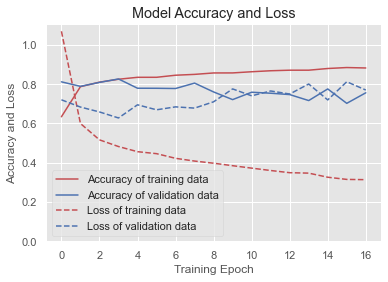

              precision    recall  f1-score   support

  Downstairs       0.61      0.40      0.49      1864
     Jogging       0.98      0.97      0.98      6567
     Sitting       0.99      0.99      0.99      1050
    Standing       0.98      0.99      0.98       833
    Upstairs       0.64      0.55      0.59      2342
     Walking       0.83      0.94      0.88      8212

    accuracy                           0.86     20868
   macro avg       0.84      0.81      0.82     20868
weighted avg       0.85      0.86      0.85     20868



In [74]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train,target_names=LABELS))

Check Against Test Data
Let’s continue with this model and see how it performs against the test data that we have held back earlier. In our case, we will check the performance against the movements of the six users that the model has not yet seen.

In [76]:
# Normalize features for test data set
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

print('x_test shape: ', x_test.shape)
print(x_test.shape[0], 'test samples')
print('y_test shape: ', y_test.shape)

y_test = utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

x_test shape:  (6584, 240)
6584 test samples
y_test shape:  (6584,)
206/206 [==============================] - 0s 2ms/step - loss: 1.1669 - accuracy: 0.7580

Accuracy on test data: 0.76

Loss on test data: 1.17


In [77]:
print(max_y_pred_test)

[1 1 1 ... 3 3 3]


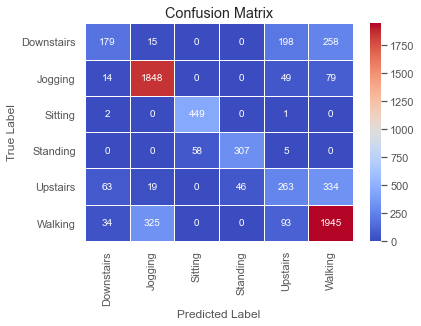

              precision    recall  f1-score   support

           0       0.61      0.28      0.38       650
           1       0.84      0.93      0.88      1990
           2       0.89      0.99      0.94       452
           3       0.87      0.83      0.85       370
           4       0.43      0.36      0.39       725
           5       0.74      0.81      0.78      2397

    accuracy                           0.76      6584
   macro avg       0.73      0.70      0.70      6584
weighted avg       0.74      0.76      0.74      6584



In [79]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))